In [2]:
!pip install tensorflow=='2.2'

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.67.78.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.67.78.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.78.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [58]:
import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm
import os
import shutil
import itertools
import tensorflow

# **Data Preparation**

In [5]:
csv_path='/content/drive/My Drive/Colab Notebooks/fer2013.csv'
data=pd.read_csv(csv_path)


In [6]:
print(data.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [7]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
outer_names = ['test','train']
inner_names = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
os.makedirs('data', exist_ok=True)
for outer_name in outer_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in inner_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

In [9]:
# convert string to integer
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n

In [10]:
# to keep count of each category
angry = 0
disgusted = 0
fearful = 0
happy = 0
sad = 0
surprised = 0
neutral = 0
angry_test = 0
disgusted_test = 0
fearful_test = 0
happy_test = 0
sad_test = 0
surprised_test = 0
neutral_test = 0

df = data
mat = np.zeros((48,48),dtype=np.uint8)
print("Saving images...")

# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()
    
    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 28709:
        if df['emotion'][i] == 0:
            img.save('data/train/angry/im'+str(angry)+'.png')
            angry += 1
        elif df['emotion'][i] == 1:
            img.save('data/train/disgusted/im'+str(disgusted)+'.png')
            disgusted += 1
        elif df['emotion'][i] == 2:
            img.save('data/train/fearful/im'+str(fearful)+'.png')
            fearful += 1
        elif df['emotion'][i] == 3:
            img.save('data/train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 4:
            img.save('data/train/sad/im'+str(sad)+'.png')
            sad += 1
        elif df['emotion'][i] == 5:
            img.save('data/train/surprised/im'+str(surprised)+'.png')
            surprised += 1
        elif df['emotion'][i] == 6:
            img.save('data/train/neutral/im'+str(neutral)+'.png')
            neutral += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('data/test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        elif df['emotion'][i] == 1:
            img.save('data/test/disgusted/im'+str(disgusted_test)+'.png')
            disgusted_test += 1
        elif df['emotion'][i] == 2:
            img.save('data/test/fearful/im'+str(fearful_test)+'.png')
            fearful_test += 1
        elif df['emotion'][i] == 3:
            img.save('data/test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 4:
            img.save('data/test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        elif df['emotion'][i] == 5:
            img.save('data/test/surprised/im'+str(surprised_test)+'.png')
            surprised_test += 1
        elif df['emotion'][i] == 6:
            img.save('data/test/neutral/im'+str(neutral_test)+'.png')
            neutral_test += 1

print("Done!")

  0%|          | 0/35887 [00:00<?, ?it/s]

Saving images...


100%|██████████| 35887/35887 [02:09<00:00, 277.91it/s]

Done!


In [22]:
import shutil
class_list=['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

for item in class_list:
  # We are creating temporary directories here because we delete these directories later
  # create a base dir
  aug_dir = 'aug_dir'
  os.mkdir(aug_dir)
  img_dir = os.path.join(aug_dir, 'img_dir')
  os.mkdir(img_dir)

  # Choose a class
  img_class = item

  # list all images in that directory
  img_list = os.listdir('data/train/' + img_class)

  # Copy images from the class train dir to the img_dir e.g. class 'bacterial'
  for fname in img_list:
    # source path to image
    src = os.path.join('data/train/' + img_class, fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
  
  # point to a dir containing the images and not to the images themselves
  path = aug_dir
  save_path = 'data/train/' + img_class

  # Create a data generator
  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      fill_mode='nearest')

  batch_size = 64

  aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                                  target_size=(48,48),
                                                  batch_size=batch_size)
  

  # Generate the augmented images and add them to the training folders
  
  ###########
  
  num_aug_images_wanted = 10000 # total number of images we want to have in each class
  
  ###########

  num_files = len(os.listdir(img_dir))
  num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

  # run the generator and create augmented images
  for i in range(0,num_batches):
    imgs, labels = next(aug_datagen)
      
  # delete temporary directory with the raw image files
  shutil.rmtree('aug_dir')

Found 3995 images belonging to 1 classes.
Found 436 images belonging to 1 classes.
Found 4097 images belonging to 1 classes.
Found 7215 images belonging to 1 classes.
Found 4830 images belonging to 1 classes.
Found 3171 images belonging to 1 classes.
Found 4965 images belonging to 1 classes.


In [29]:
class_list=['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
total_images=0;
for item in class_list: 
  total_images+=len(os.listdir('data/train/'+item))
# print(len(os.listdir('base_dir/train_dir/bacterial')))
# print(len(os.listdir('base_dir/train_dir/viral')))
print(total_images)

69710


**Data Preparation Done**

# **Model Building With Data Generators**

In [53]:
import matplotlib.pyplot as plt
import cv2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


from sklearn.metrics import confusion_matrix

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
# from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

In [26]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

In [30]:
num_train = total_images
num_val = 7178
batch_size = 256
num_epoch = 50

In [31]:
# Define data generators
train_dir = 'data/train'
val_dir = 'data/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 69710 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [32]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

In [17]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

Epoch 1/50
272/272 [==============================] - 55s 202ms/step - loss: 1.8919 - accuracy: 0.2105 - categorical_accuracy: 0.2105 - val_loss: 1.8097 - val_accuracy: 0.2900 - val_categorical_accuracy: 0.2900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29004, saving model to face_emotion_model.h5
Epoch 2/50
272/272 [==============================] - 55s 202ms/step - loss: 1.7240 - accuracy: 0.3334 - categorical_accuracy: 0.3334 - val_loss: 1.6401 - val_accuracy: 0.3847 - val_categorical_accuracy: 0.3847

Epoch 00002: val_categorical_accuracy improved from 0.29004 to 0.38472, saving model to face_emotion_model.h5
Epoch 3/50
272/272 [==============================] - 55s 203ms/step - loss: 1.6199 - accuracy: 0.3825 - categorical_accuracy: 0.3825 - val_loss: 1.5439 - val_accuracy: 0.4218 - val_categorical_accuracy: 0.4218

Epoch 00003: val_categorical_accuracy improved from 0.38472 to 0.42184, saving model to face_emotion_model.h5
Epoch 4/50
272/272 [=================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


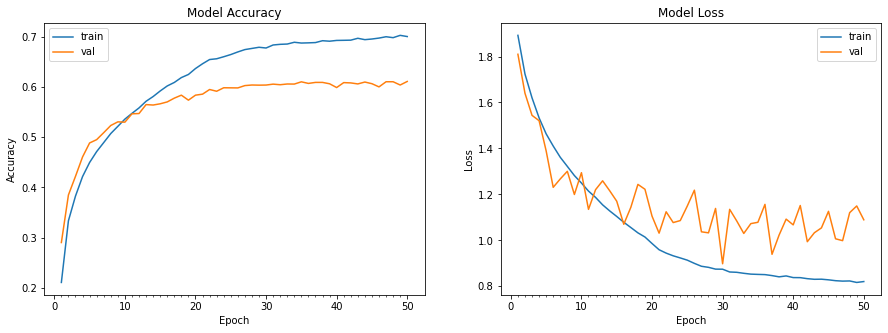

In [34]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy',categorical_accuracy])
filepath = "face_emotion_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]
model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val//batch_size,
        callbacks=callbacks_list
        )
plot_model_history(model_info)
model.save_weights('face_emotion_final_epoch_model.h5')

In [35]:
model.metrics_names

['loss', 'accuracy', 'categorical_accuracy']

In [46]:
# Note: shuffle=False causes the test dataset to not be shuffled
test_datagen = ImageDataGenerator(rescale=1./255)
test_steps = np.ceil(7178 / 64)
test_batches= test_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

val_loss,val_acc ,val_cat_acc = model.evaluate_generator(test_batches, 
                        steps=test_steps)

print('val_loss:', val_loss)
print('val_acc', val_acc)
print('val_cat_acc:', val_cat_acc)

Found 7178 images belonging to 7 classes.
val_loss: 1.1893070936203003
val_acc 0.6062970161437988
val_cat_acc: 0.6062970161437988


In [47]:
model.load_weights('face_emotion_model.h5')

val_loss, val_acc, val_cat_acc = \
val_loss,val_acc ,val_cat_acc = model.evaluate_generator(test_batches, 
                        steps=test_steps)
print('val_loss:', val_loss)
print('val_acc', val_acc)
print('val_cat_acc:', val_cat_acc)

val_loss: 1.1893070936203003
val_acc 0.6062970161437988
val_cat_acc: 0.6062970161437988


In [48]:
# Get the labels of the test images.

test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [49]:
# Print the label associated with each class
test_batches.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [50]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=test_steps, verbose=1)

113/113 [==============================] - 2s 19ms/step


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [54]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [55]:
test_batches.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

Confusion matrix, without normalization
[[ 497   31   87   56  125  130   32]
 [  17   76    6    2    5    4    1]
 [ 115   20  380   57  126  206  120]
 [  62    3   54 1425  111   68   51]
 [  81   10   81  112  744  174   31]
 [ 132   22  148   91  241  583   30]
 [  24    4   60   37   41   18  647]]


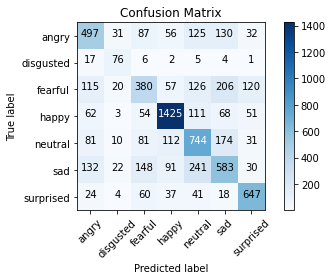

In [59]:
# order shown above.
cm_plot_labels = ['angry',
 'disgusted',
 'fearful',
 'happy',
 'neutral',
 'sad',
 'surprised']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [60]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_batches.filenames

# Get the true labels
y_true = test_batches.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [61]:
from sklearn.metrics import classification_report

# Generate a classification report


report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       angry       0.54      0.52      0.53       958
   disgusted       0.46      0.68      0.55       111
     fearful       0.47      0.37      0.41      1024
       happy       0.80      0.80      0.80      1774
     neutral       0.53      0.60      0.57      1233
         sad       0.49      0.47      0.48      1247
   surprised       0.71      0.78      0.74       831

    accuracy                           0.61      7178
   macro avg       0.57      0.60      0.58      7178
weighted avg       0.60      0.61      0.60      7178



In [62]:
model.save('face_emotion_final_weights_model.h5')